### Global Imports

In [1]:
import os
import datetime
import errno
import argparse

import numpy as np
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

Using TensorFlow backend.


### Model Zoo

In [ ]:
import numpy as np
import tensorflow as tf



from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv3D, ConvLSTM2D, LSTM
from tensorflow.python.keras.layers import Add, Input, Concatenate, Lambda, InputLayer
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Reshape
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D
from tensorflow.python.keras.layers import Cropping2D, Cropping3D
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import ZeroPadding2D, ZeroPadding3D
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.regularizers import l2

from deepcell.layers import Resize
from deepcell.layers import DilatedMaxPool2D, DilatedMaxPool3D
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from deepcell.layers import Location, Location3D
from deepcell.layers import ReflectionPadding2D, ReflectionPadding3D
from deepcell.layers import TensorProd2D, TensorProd3D

def siamese_model(input_shape=None, track_length=1, occupancy_grid_size=10, reg=1e-5, init='he_normal', softmax=True, norm_method='std', filter_size=61):

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        new_input_shape = tuple([input_shape[0]] + [None] + list(input_shape[1:]))
    else:
        channel_axis = -1
        new_input_shape = tuple([None] + list(input_shape))
        
    input_shape = new_input_shape
        
    # Define the input shape for the images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    # Define the input shape for the other data (centroids, etc)
    input_3 = Input(shape=(None, 2))
    input_4 = Input(shape=(None, 2))
    
    input_5 = Input(shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1))
    input_6 = Input(shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1))

    # Feature extractor for images
    N_layers = np.int(np.floor(np.log2(in_shape[0])))
    feature_extractor = Sequential()
    feature_extractor.add(InputLayer(input_shape=input_shape))
    for layer in range(N_layers):
        feature_extractor.add(Conv3D(64, (1, 3, 3), kernel_initializer=init, padding='same', 
                                     kernel_regularizer=l2(reg)))
        feature_extractor.add(BatchNormalization(axis=channel_axis))
        feature_extractor.add(Activation('relu'))
        feature_extractor.add(MaxPool3D(pool_size=(1, 2, 2)))

    feature_extractor.add(Reshape(tuple([-1, 64])))
    
    # Feature extractor for occupancy grids
    N_layers_og = np.int(np.floor(np.log2(2*occupancy_grid_size+1)))
    feature_extractor_occupancy_grid = Sequential()
    feature_extractor_occupancy_grid.add(InputLayer(input_shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1)))   
    for layer in range(N_layers_og):
        feature_extractor_occupancy_grid.add(Conv3D(64, (1, 3, 3), kernel_initializer=init, padding='same', 
                                                    kernel_regularizer=l2(reg)))
        feature_extractor_occupancy_grid.add(BatchNormalization(axis=channel_axis))
        feature_extractor_occupancy_grid.add(Activation('relu'))
        feature_extractor_occupancy_grid.add(MaxPool3D(pool_size=(1, 2, 2)))
    
    feature_extractor_occupancy_grid.add(Reshape(tuple([-1, 64])))

    # Apply feature extractor to appearances
    output_1 = feature_extractor(input_1)
    output_2 = feature_extractor(input_2)
    
    lstm_1 = LSTM(64)(output_1)
    output_2_reshape = Reshape((64,))(output_2)
    
    # Centroids
    lstm_3 = LSTM(64)(input_3)
    input_4_reshape = Reshape((2,))(input_4)

    # Apply feature extractor to occupancy grids
    output_5 = feature_extractor_occupancy_grid(input_5)
    output_6 = feature_extractor_occupancy_grid(input_6)
    
    lstm_5 = LSTM(64)(output_5)
    output_6_reshape = Reshape((64,))(output_6)
    
    # Combine the extracted features with other known features (centroids)
    merge_1 = Concatenate(axis=channel_axis)([lstm_1, output_2_reshape])
    merge_2 = Concatenate(axis=channel_axis)([lstm_3, input_4_reshape])
    merge_3 = Concatenate(axis=channel_axis)([lstm_5, output_6_reshape])
    
    dense_merge_1 = Dense(128)(merge_1)
    bn_merge_1 = BatchNormalization(axis=channel_axis)(dense_merge_1)
    dense_relu_1 = Activation('relu')(bn_merge_1)
    
    dense_merge_2 = Dense(128)(merge_2)
    bn_merge_2 = BatchNormalization(axis=channel_axis)(dense_merge_2)
    dense_relu_2 = Activation('relu')(bn_merge_2)
    
    dense_merge_3 = Dense(128)(merge_3)
    bn_merge_3 = BatchNormalization(axis=channel_axis)(dense_merge_3)
    dense_relu_3 = Activation('relu')(bn_merge_3)
    
    # Concatenate outputs from both instances
    merged_outputs = Concatenate(axis=channel_axis)([dense_relu_1, dense_relu_2, dense_relu_3])

    # Add dense layers
    dense1 = Dense(128)(merged_outputs)
    bn1 = BatchNormalization(axis=channel_axis)(dense1)
    relu1 = Activation('relu')(bn1)
    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization(axis=channel_axis)(dense2)
    relu2 = Activation('relu')(bn2)
    dense3 = Dense(3, activation='softmax')(relu2)

    # Instantiate model
    final_layer = dense3
    model = Model(inputs=[input_1, input_2, input_3, input_4, input_5, input_6], outputs=final_layer)

    return model

### Training the Model

In [ ]:
from deepcell import rate_scheduler

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela0-7_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.001, decay=0.99)
in_shape = (32, 32, 1)
model = siamese_model(input_shape=in_shape)

tracking_model = train_model_siamese_daughter(model=model,
                    dataset=dataset,
                    optimizer=optimizer,
                    expt='',
                    it=0,
                    batch_size=128,
                    min_track_length=5,
                    n_epoch=5,
                    direc_save='/data/models/cells/HeLa/S3',
                    direc_data=direc_data,
                    lr_sched=lr_sched,
                    rotation_range=180,
                    flip=True,
                    shear=0,
                    class_weight=None)

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Tracking Test

In [2]:
# Import the tracking function
from deepcell.tracking import cell_tracker

# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [3]:
# Import the tracking model
MODEL_DIR = '/data/models'
PREFIX = 'cells/HeLa/S3'
in_shape = (32, 32, 1)

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-09-07_nuclear_movie_hela0-7_same__0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model = siamese_model(input_shape=in_shape)
tracking_model.load_weights(siamese_weights_file)

In [19]:
batch = 0

trial = cell_tracker(train_dict['X'][batch], train_dict['y'][batch], tracking_model, max_distance=1000, track_length=5, division=0.5, birth=0.9, death=0.9)
trial._track_cells()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Tracking frame 1
[0.03 0.01 0.04 0.01 0.   0.01 0.  ]
New track
Tracking frame 2
Tracking frame 3
Tracking frame 4
Tracking frame 5
Tracking frame 6
Tracking frame 7
[0.   0.02 0.22 0.08 0.   0.01 0.   0.  ]
New track
Tracking frame 8
Tracking frame 9
Tracking frame 10
Tracking frame 11
Tracking frame 12
Tracking frame 13
Tracking frame 14
Tracking frame 15
Tracking frame 16
Tracking frame 17
Tracking frame 18
Tracking frame 19
Tracking frame 20
Tracking frame 21
Tracking frame 22
Tracking frame 23
Tracking frame 24
Tracking frame 25
Tracking frame 26
Tracking frame 27
Tracking frame 28
Tracking frame 29
Tracking frame 30
Tracking frame 31
Tracking frame 32
Tracking frame 33
Tracking frame 34
Tracking frame 35
Tracking frame 36
Tracking frame 37
Tracking frame 38
Tracking frame 39


### Visualizing the Result

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='jet', vmin=0, vmax=10)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    return HTML(ani.to_jshtml())

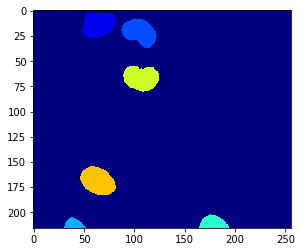

In [23]:
get_js_video(train_dict['y'], batch=batch)

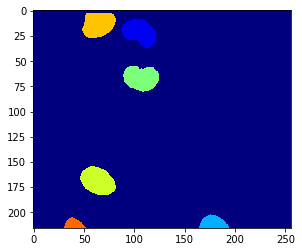

In [22]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

In [ ]:
print(trial.y_tracked.shape)

In [ ]:
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print([key for key in trial.tracks.keys()])
print(trial.tracks[6]['frames'])
print(trial.tracks[8]['frames'])
print(trial.tracks[9]['frames'])

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))